# TV Script Generation
In this notebook, we'll construct an RNN model to generate television scripts for a TV show. 

The notebook implements some ideas found from [this /r/machinelearning post](https://www.reddit.com/r/MachineLearning/comments/3psqil/sentence_to_sentence_text_generation_using_lstms/), [this paper on applying dropout to LSTM units](https://arxiv.org/pdf/1409.2329.pdf), and [this paper on output embedding for language models](https://arxiv.org/pdf/1409.2329.pdf).

In [1]:
import torch

GPU_AVAILABLE = torch.cuda.is_available()
GPU_AVAILABLE

True

## Preprocessing the data

To start, we can use the [The Simpsons by the Data](https://www.kaggle.com/wcukierski/the-simpsons-by-the-data) dataset from Kaggle.

The tv scripts are originally in .csv format, but since we're only going to train our model on the raw text of the scripts, I've converted the .csv into a simple text file, [here](./data/simpsons/simpsons_script_lines.txt). 

I've also split the original dataset into 50% [training](./data/simpsons/train.txt), 25% [testing](./data/simpsons/test.txt), and 25% [validation](valid.txt) sets.

In [2]:
%%bash
tail ./data/simpsons/simpsons_script_lines.txt

Marge Simpson: Yes.
Lisa Simpson: Can we do it this week?
(Springfield Elementary School: INT. ELEMENTARY - HALLWAY)
Lisa Simpson: (REHEARSING) Mr. Bergstrom, we request the pleasure of your company... no... Mr. Bergstrom, if you're not doing anything this Friday... no... Mr. Bergstrom, do you like pork chops... oh no, of course you wouldn't...
Miss Hoover: Good morning, Lisa.
Miss Hoover: (OFF LISA'S REACTION) I'm back.
Miss Hoover: You see, class, my Lyme disease turned out to be...
Miss Hoover: Psy-cho-so-ma-tic.
Ralph Wiggum: Does that mean you were crazy?
JANEY: No, that means she was faking it.

In the snippet above, there are three instances of the word `no`. Unfortunately, when we start adding words to our dictionary, `no...` and `no,` will be treated as entirely different words. To remedy this, we can create a token lookup function to map special characters to their own words:

In [3]:
def token_lookup():
    return {
        '.': '||period||',
        ',': '||comma||',
        '"': '||quotation_mark||',
        ';': '||semicolon||',
        '!': '||exclamation_mark',
        '?': '||question_mark',
        '(': '||l_parantheses||',
        ')': '||r_parantheses||',
        '-': '||dash||',
        '\'': '||apostrophe||',
        '\n': '||return||'
    }

### Dictionary Class
The Dictionary can hold our text encodings for later referral. It will also have a helper function to easily query the number of words and to add words to the dictionary instance.

In [4]:
import os
import torch

class Dictionary(object):
    def __init__(self):
        self.word_to_idx = {}
        self.idx_to_word = []
        
    def add_word(self, word):
        if word not in self.word_to_idx:
            self.idx_to_word.append(word)
            self.word_to_idx[word] = len(self.idx_to_word) -1
        return self.word_to_idx[word]
    
    def __len__(self):
        return len(self.idx_to_word)

### Corpus Class
The Corpus can contain the training, testing, and validation sets for the model, as well as a dictionary of words. The corpus is capable of tokenizing its data to help with punctuation and capitalization. Note that the tokenization adds delimeters around the tokenized punctuation.

In [5]:
class Corpus(object):
    def __init__(self, path):
        self.dictionary = Dictionary()
        self.train = self.tokenize(os.path.join(path, 'train.txt'))
        self.test = self.tokenize(os.path.join(path, 'test.txt'))
        self.valid = self.tokenize(os.path.join(path, 'valid.txt'))
        
    def tokenize(self, path):
        assert os.path.exists(path), "Could not find file matching %s" % path
        
        # Add words to the diictionary
        with open(path, 'r') as f:
            tokens = 0
            for line in f:
                for key, tok in token_lookup().items():
                    line = line.replace(key, ' {} '.format(tok))
                line = line.lower()
                
                words = line.split() + ['||return||']
                tokens += len(words)
                
                for word in words:
                    self.dictionary.add_word(word)
        
        # Tokenize the words and return a LongTensor of ids
        with open(path, 'r') as f:
            ids = torch.LongTensor(tokens)
            token = 0
            for line in f:
                for key, tok in token_lookup().items():
                    line = line.replace(key, ' {} '.format(tok))
                line = line.lower()
                words = line.split() + ['||return||']
                
                for word in words:
                    ids[token] = self.dictionary.word_to_idx[word]
                    token += 1
        return ids            

### Load the Data
With those two classes, we can actually load our data:

In [6]:
pathname = './data/simpsons/'
corpus = Corpus(pathname)

### Batch the data
We need to split up our data into batches for training. We can do so with a batchify method like so:

In [7]:
def batchify(data, batch_size):
    # Work out how cleanly we can divide the dataset into :batch_size: parts
    n_batches = data.size(0) // batch_size
    
    # Trim off any extra elements that wouldn't cleanly fit (remainders)
    data = data.narrow(0, 0, n_batches * batch_size)
    
    # Evenly divide the data across the :batch_size: batches.
    data = data.view(batch_size, -1).t().contiguous()
    
    if GPU_AVAILABLE:
        data = data.cuda()
    
    return data

In [8]:
evaluation_batch_size = 10
batch_size = 256
train_data = batchify(corpus.train, batch_size)
test_data = batchify(corpus.test, evaluation_batch_size)
validation_data = batchify(corpus.valid, evaluation_batch_size)
n_tokens = len(corpus.dictionary)

## Build the Model

In [9]:
import torch.nn as nn
from torch.autograd import Variable

class RNNModel(nn.Module):
    def __init__(self, n_tokens, n_inputs, n_hidden, n_layers, dropout=0.5):
        super(RNNModel, self).__init__()
        
        # Randomly zeroes some of the elements of
        #  the input tensor with probability :dropout:
        #  using samples from a bernoulli distribution
        self.dropout = nn.Dropout(dropout)
        
        # A simple lookup table that stores embeddings 
        #  of a fixed dictionary and size.
        # We are using it to store word embeddings
        self.encoder = nn.Embedding(n_tokens, n_inputs)
        
        # A multi-layer long short-term memory cell
        self.rnn = nn.LSTM(n_inputs, n_hidden, n_layers, dropout=dropout)
        
        # A layer to apply a linear transformation to the incoming data
        self.decoder = nn.Linear(n_hidden, n_tokens)
        
        # Tie the weights
        if n_hidden != n_inputs:
            print('WARNING: n_hidden must equal n_inputs to tie weights.')
            print('Setting n_hidden to n_inputs.')
            n_hidden = n_inputs
        
        self.decoder.weight = self.encoder.weight
        
        self.init_weights()
        
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        
    def init_weights(self):
        # Initialize the weights of our encoder and decoder with random 
        #  values sampled from a uniform distribution over (-0.1, 0.1).
        # Also set the bias of our linear transformation to 0
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.fill_(0)
        self.decoder.weight.data.uniform_(-initrange, initrange)
        
    def forward(self, input, hidden):
        # At every call, run the input through here
        embedding = self.dropout(self.encoder(input))
        output, hidden = self.rnn(embedding, hidden)
        output = self.dropout(output)
        decoded = self.decoder(output.view(output.size(0)*output.size(1), output.size(2)))
        return decoded.view(output.size(0), output.size(1), decoded.size(1)), hidden
    
    def init_hidden(self, batch_size):
        # Initialize the hidden layer with zeros
        weight = next(self.parameters()).data
        
        return (
            Variable(weight.new(self.n_layers, batch_size, self.n_hidden).zero_()),
            Variable(weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        )

### Define the Hyperparameters

In [10]:
embedding_size = 250
num_hidden = 250
dropout_probability = 0.65
num_epochs = 50
num_layers = 2
num_tokens = len(corpus.dictionary)
sequence_length = 20
learning_rate = 10.0
gradient_clipping = 0.3
logging_interval = 250

### Build the Model

In [11]:
model = RNNModel(num_tokens, embedding_size, num_hidden, num_layers, dropout_probability)

if GPU_AVAILABLE:
    model.cuda()

### Define our Criterion
We will calculate loss based off of PyTorch's `nn.CrossEntropyLoss`. This criterion performs a `Log(SoftMax(x))` function to a tensor, and passes the result to a negative log likelihood function.

In [12]:
criterion = nn.CrossEntropyLoss()

## Train the Model

`repackage_hidden_states` detaches variables from their history to avoid backpropogating through the entire training history

In [13]:
def repackage_hidden_states(h):
    if type(h) == Variable:
        return Variable(h.data)
    else:
        return tuple(repackage_hidden_states(v) for v in h)

`get_batch` gets a batch to use in each training or evaluation pass

In [14]:
def get_batch(source, i, evaluation=False):
    sequence_len = min(sequence_length, len(source)-1-i)
    data = Variable(source[i:i+sequence_len], volatile=evaluation)
    target = Variable(source[i+1:i+1+sequence_len].view(-1))
    
    return data, target

`evaluate` Turns on evaluation mode, which disables dropout.

In [15]:
def evaluate(data_source):
    model.eval()
    total_loss = 0
    ntok = len(corpus.dictionary)
    hidden = model.init_hidden(evaluation_batch_size)
    
    for i in range(0, data_source.size(0) -1, sequence_length):
        data, targets = get_batch(data_source, i, evaluation=True)
        output, hidden = model(data, hidden)
        output_flat = output.view(-1, ntok)
        total_loss += len(data) * criterion(output_flat, targets).data
        hidden = repackage_hidden_states(hidden)
    return total_loss[0] / len(data_source)

In [16]:
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter 

def train():
    lr = learning_rate
    best_validation_loss = None
    iteration = 0
    losses = np.zeros(0)
    learning_rates = np.zeros(0)
    
    for epoch in range(1, num_epochs+1):
        epoch_start_time = time.time()
        
        model.train()
        total_loss = 0
        n_tokens = len(corpus.dictionary)
        hidden = model.init_hidden(batch_size)
        start_time = time.time()

        for batch, i in enumerate(range(0, train_data.size(0) - 1, sequence_length)):
            iteration += 1
            data, targets = get_batch(train_data, i)

            hidden = repackage_hidden_states(hidden)
            model.zero_grad()
            output, hidden = model(data, hidden)
            loss = criterion(output.view(-1, n_tokens), targets)
            loss.backward()

            # clip_grad_norm prevents the exploding gradient problem in RNNs and LSTMs
            torch.nn.utils.clip_grad_norm(model.parameters(), gradient_clipping)

            for p in model.parameters():
                p.data.add_(-lr, p.grad.data)

            total_loss += loss.data
            losses = np.resize(losses, iteration)
            learning_rates = np.resize(learning_rates, iteration)
            np.put(losses, [iteration-1], [loss.data[0]])
            np.put(learning_rates, [iteration-1], [lr])

            if batch % logging_interval == 0 and batch > 0 and iteration > 10:
                current_loss = total_loss[0] / logging_interval
                elapsed = time.time() - start_time
                print('Epoch {}/{} batches: {}/{} lr {:.2f}, loss {:.2f}, perplexity: {:.2f}'.format(
                        epoch, num_epochs, batch, len(train_data) // sequence_length, lr, current_loss, math.exp(current_loss))
                     )
                iterations = np.arange(iteration)
                first_clip = np.arange(1)
                max_p = losses.copy().data[0] + (losses.data[0]/6)
                max_lr = learning_rates.copy().data[0] + (learning_rates.data[0]/6)
                
                fig, ax1 = plt.subplots()
                ax2 = ax1.twinx()
                ax1.set_xlabel('Iteration #')
                ax1.set_ylabel('Loss')
                ax2.set_ylabel('Learning Rate')
                ax2.set_ylim([0, max_lr])
                ax1.set_ylim([0, max_p])

                
                if(iteration == 11):
                    iterations = np.delete(iterations, first_clip)
                    losses = np.delete(losses, first_clip)
                    learning_rates = np.delete(learning_rates, first_clip)
                
                ax1.plot(iterations, losses, 'b-')
                ax2.plot(iterations, learning_rates, 'g-')
            
                plt.show()
                
                total_loss = 0
        validation_loss = evaluate(validation_data)
        
        print('='*76)
        print('Epoch {:3d} results: time: {:5.2f}s, validation loss {:5.2f}, perplexity {:8.2f}'.format(
            epoch, (time.time() - epoch_start_time), validation_loss, math.exp(validation_loss)
        ))
        print('='*76)

        
        # If the model's validation loss is the best we've seen, save the model
        if not best_validation_loss or validation_loss < best_validation_loss:
            with open('model_checkpoint.pt', 'wb') as f:
                torch.save(model, f)
            best_validation_loss = validation_loss
        else:
            # Anneal the learning rate if no improvement has been seen in the validation dataset
            lr /= 4.0

Epoch 1/50 batches: 250/363 lr 10.00, loss 6.79, perplexity: 885.87


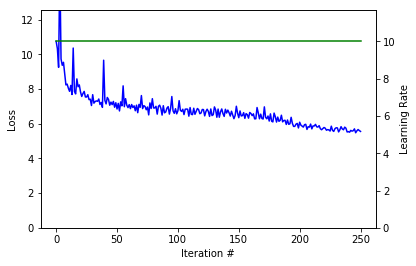

Epoch   1 results: time: 84.08s, validation loss  4.97, perplexity   143.98


/home/tyson/anaconda3/envs/ml/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type RNNModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch 2/50 batches: 250/363 lr 10.00, loss 4.87, perplexity: 129.99


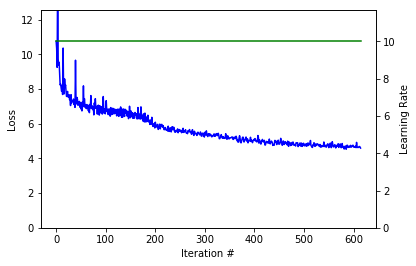

Epoch   2 results: time: 84.23s, validation loss  4.48, perplexity    88.24
Epoch 3/50 batches: 250/363 lr 10.00, loss 4.51, perplexity: 90.97


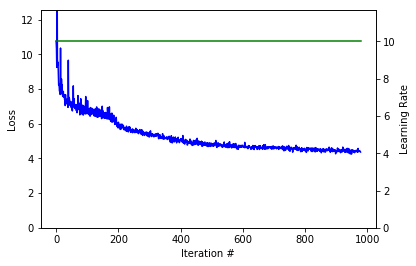

Epoch   3 results: time: 84.26s, validation loss  4.29, perplexity    72.65
Epoch 4/50 batches: 250/363 lr 10.00, loss 4.35, perplexity: 77.74


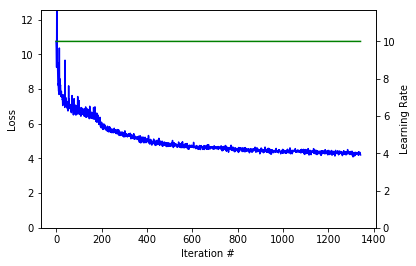

Epoch   4 results: time: 83.83s, validation loss  4.20, perplexity    66.69
Epoch 5/50 batches: 250/363 lr 10.00, loss 4.25, perplexity: 70.08


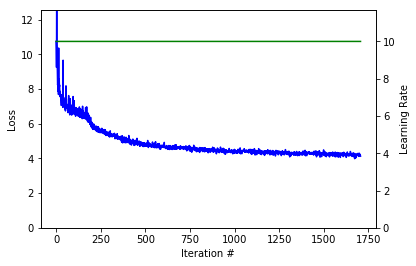

Epoch   5 results: time: 83.94s, validation loss  4.12, perplexity    61.83
Epoch 6/50 batches: 250/363 lr 10.00, loss 4.18, perplexity: 65.21


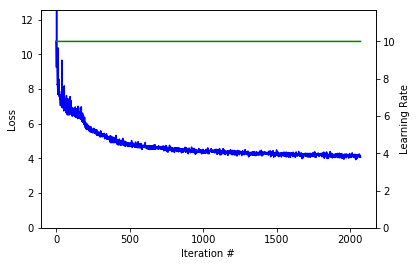

Epoch   6 results: time: 84.37s, validation loss  4.07, perplexity    58.39
Epoch 7/50 batches: 250/363 lr 10.00, loss 4.12, perplexity: 61.41


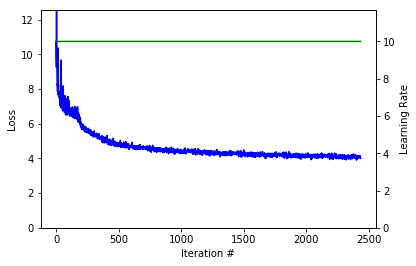

Epoch   7 results: time: 83.34s, validation loss  4.04, perplexity    56.57
Epoch 8/50 batches: 250/363 lr 10.00, loss 4.07, perplexity: 58.83


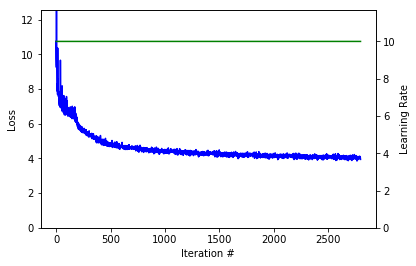

Epoch   8 results: time: 82.89s, validation loss  4.02, perplexity    55.96
Epoch 9/50 batches: 250/363 lr 10.00, loss 4.04, perplexity: 56.72


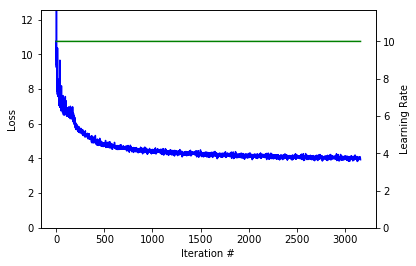

Epoch   9 results: time: 83.16s, validation loss  3.98, perplexity    53.67
Epoch 10/50 batches: 250/363 lr 10.00, loss 4.01, perplexity: 54.96


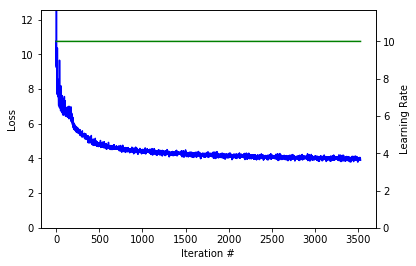

Epoch  10 results: time: 82.94s, validation loss  3.96, perplexity    52.38
Epoch 11/50 batches: 250/363 lr 10.00, loss 3.98, perplexity: 53.61


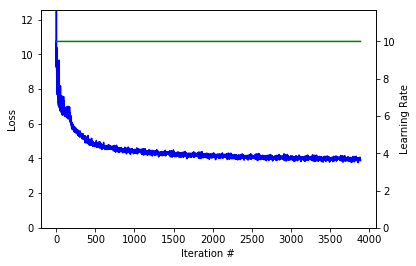

Epoch  11 results: time: 82.85s, validation loss  3.92, perplexity    50.60
Epoch 12/50 batches: 250/363 lr 10.00, loss 3.96, perplexity: 52.38


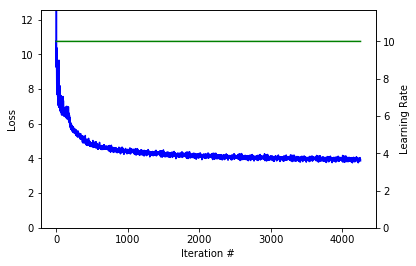

Epoch  12 results: time: 82.91s, validation loss  3.91, perplexity    49.75
Epoch 13/50 batches: 250/363 lr 10.00, loss 3.94, perplexity: 51.20


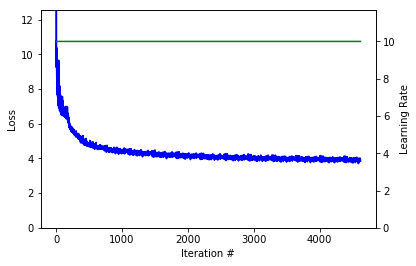

Epoch  13 results: time: 83.04s, validation loss  3.89, perplexity    49.02
Epoch 14/50 batches: 250/363 lr 10.00, loss 3.92, perplexity: 50.29


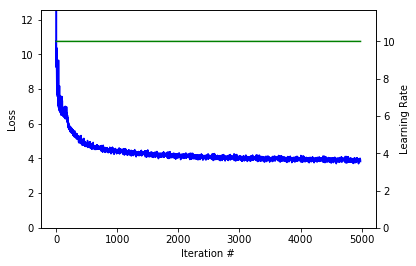

Epoch  14 results: time: 82.86s, validation loss  3.88, perplexity    48.43
Epoch 15/50 batches: 250/363 lr 10.00, loss 3.90, perplexity: 49.50


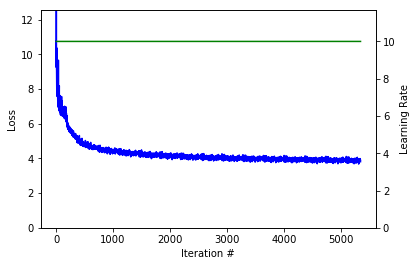

Epoch  15 results: time: 82.91s, validation loss  3.87, perplexity    47.88
Epoch 16/50 batches: 250/363 lr 10.00, loss 3.88, perplexity: 48.66


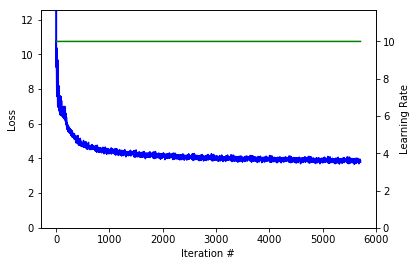

Epoch  16 results: time: 82.85s, validation loss  3.87, perplexity    47.91
Epoch 17/50 batches: 250/363 lr 2.50, loss 3.85, perplexity: 46.96


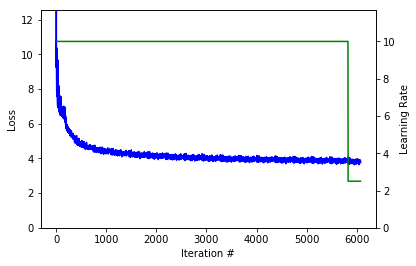

Epoch  17 results: time: 83.21s, validation loss  3.83, perplexity    46.12
Epoch 18/50 batches: 250/363 lr 2.50, loss 3.84, perplexity: 46.43


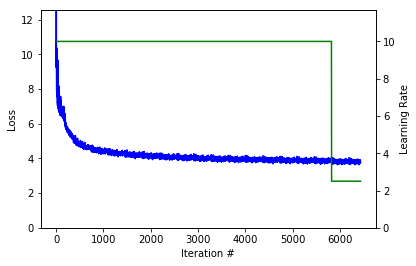

Epoch  18 results: time: 82.97s, validation loss  3.83, perplexity    45.95
Epoch 19/50 batches: 250/363 lr 2.50, loss 3.83, perplexity: 46.21


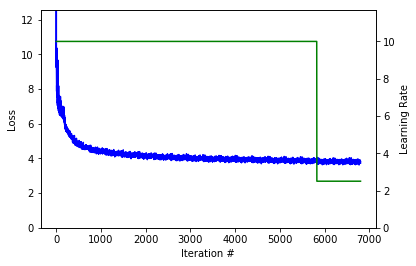

Epoch  19 results: time: 83.08s, validation loss  3.82, perplexity    45.81
Epoch 20/50 batches: 250/363 lr 2.50, loss 3.83, perplexity: 45.98


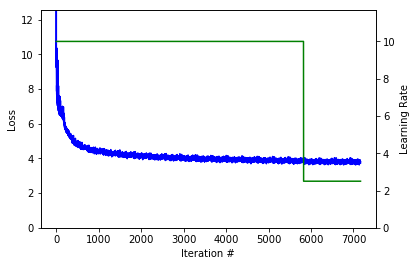

Epoch  20 results: time: 83.12s, validation loss  3.82, perplexity    45.66
Epoch 21/50 batches: 250/363 lr 2.50, loss 3.82, perplexity: 45.80


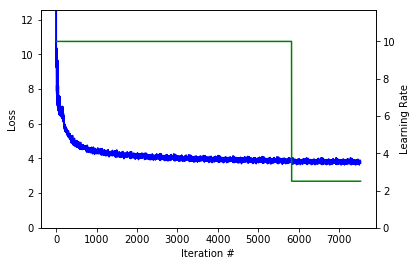

Epoch  21 results: time: 83.06s, validation loss  3.82, perplexity    45.60
Epoch 22/50 batches: 250/363 lr 2.50, loss 3.82, perplexity: 45.63


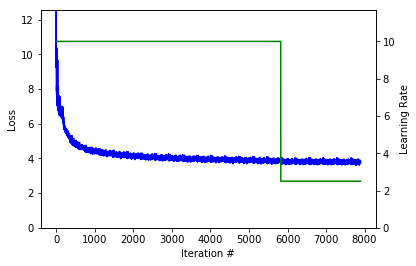

Epoch  22 results: time: 83.03s, validation loss  3.82, perplexity    45.50
Epoch 23/50 batches: 250/363 lr 2.50, loss 3.82, perplexity: 45.40


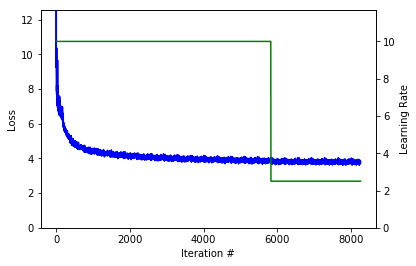

Epoch  23 results: time: 82.94s, validation loss  3.82, perplexity    45.39
Epoch 24/50 batches: 250/363 lr 2.50, loss 3.81, perplexity: 45.20


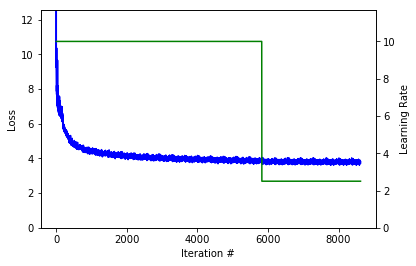

Epoch  24 results: time: 83.21s, validation loss  3.81, perplexity    45.26
Epoch 25/50 batches: 250/363 lr 2.50, loss 3.81, perplexity: 45.08


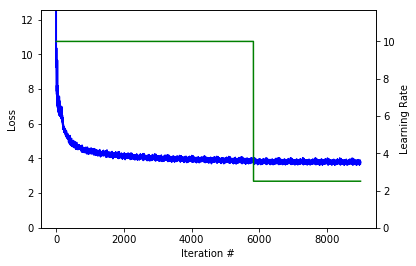

Epoch  25 results: time: 82.97s, validation loss  3.81, perplexity    45.18
Epoch 26/50 batches: 250/363 lr 2.50, loss 3.81, perplexity: 44.97


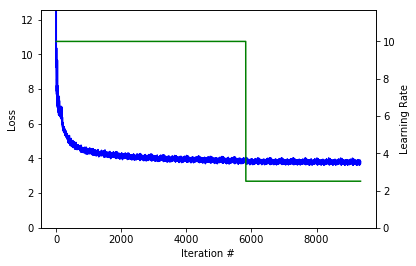

Epoch  26 results: time: 83.01s, validation loss  3.81, perplexity    45.05
Epoch 27/50 batches: 250/363 lr 2.50, loss 3.80, perplexity: 44.81


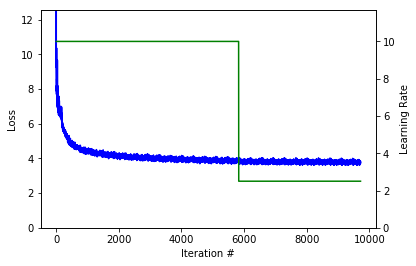

Epoch  27 results: time: 83.20s, validation loss  3.81, perplexity    44.99
Epoch 28/50 batches: 250/363 lr 2.50, loss 3.80, perplexity: 44.66


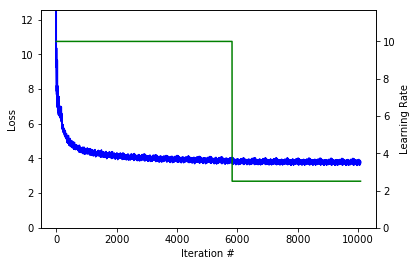

Epoch  28 results: time: 82.95s, validation loss  3.80, perplexity    44.92
Epoch 29/50 batches: 250/363 lr 2.50, loss 3.80, perplexity: 44.52


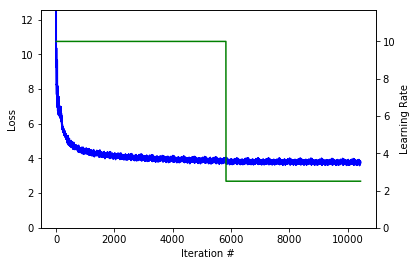

Epoch  29 results: time: 82.93s, validation loss  3.80, perplexity    44.80
Epoch 30/50 batches: 250/363 lr 2.50, loss 3.79, perplexity: 44.38


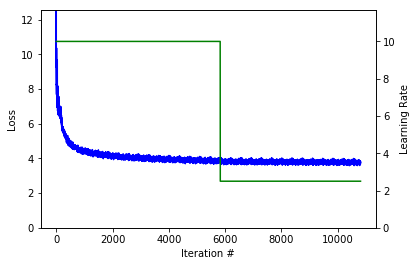

Epoch  30 results: time: 83.04s, validation loss  3.80, perplexity    44.77
Epoch 31/50 batches: 250/363 lr 2.50, loss 3.79, perplexity: 44.23


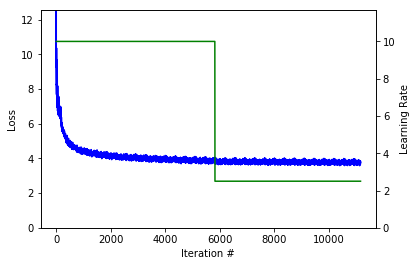

Epoch  31 results: time: 83.27s, validation loss  3.80, perplexity    44.66
Epoch 32/50 batches: 250/363 lr 2.50, loss 3.79, perplexity: 44.17


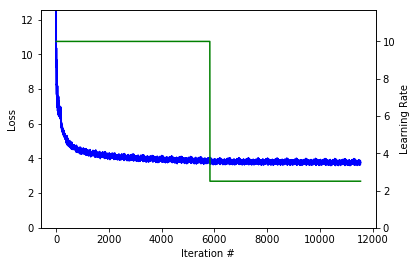

Epoch  32 results: time: 83.05s, validation loss  3.80, perplexity    44.60
Epoch 33/50 batches: 250/363 lr 2.50, loss 3.78, perplexity: 43.94


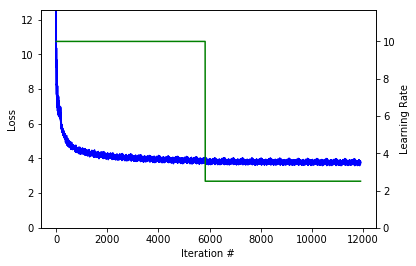

Epoch  33 results: time: 83.02s, validation loss  3.80, perplexity    44.49
Epoch 34/50 batches: 250/363 lr 2.50, loss 3.78, perplexity: 43.86


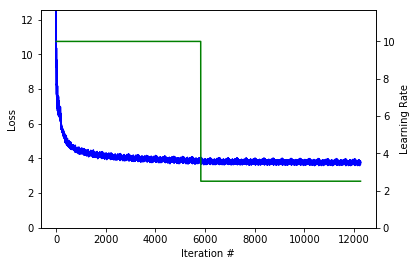

Epoch  34 results: time: 83.10s, validation loss  3.79, perplexity    44.44
Epoch 35/50 batches: 250/363 lr 2.50, loss 3.78, perplexity: 43.78


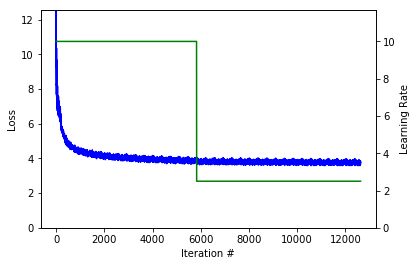

Epoch  35 results: time: 83.24s, validation loss  3.79, perplexity    44.39
Epoch 36/50 batches: 250/363 lr 2.50, loss 3.78, perplexity: 43.63


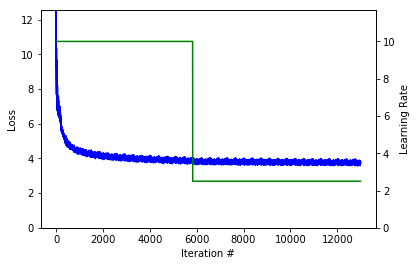

Epoch  36 results: time: 82.99s, validation loss  3.79, perplexity    44.34
Epoch 37/50 batches: 250/363 lr 2.50, loss 3.77, perplexity: 43.55


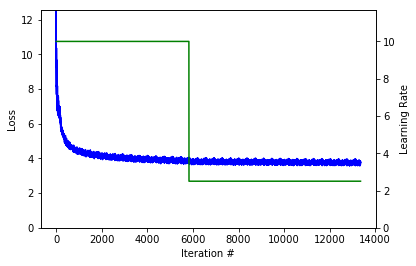

Epoch  37 results: time: 83.04s, validation loss  3.79, perplexity    44.24
Epoch 38/50 batches: 250/363 lr 2.50, loss 3.77, perplexity: 43.40


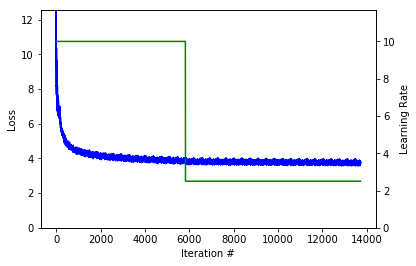

Epoch  38 results: time: 83.23s, validation loss  3.79, perplexity    44.15
Epoch 39/50 batches: 250/363 lr 2.50, loss 3.77, perplexity: 43.33


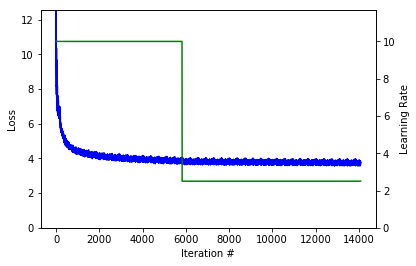

Epoch  39 results: time: 83.03s, validation loss  3.79, perplexity    44.10
Epoch 40/50 batches: 250/363 lr 2.50, loss 3.77, perplexity: 43.17


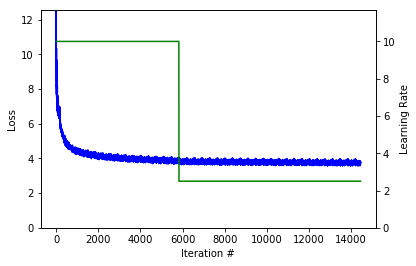

Epoch  40 results: time: 82.97s, validation loss  3.78, perplexity    44.01
Epoch 41/50 batches: 250/363 lr 2.50, loss 3.76, perplexity: 43.08


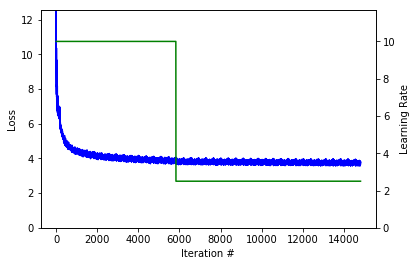

Epoch  41 results: time: 82.94s, validation loss  3.78, perplexity    43.99
Epoch 42/50 batches: 250/363 lr 2.50, loss 3.76, perplexity: 42.99


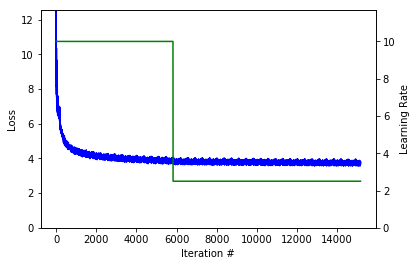

Epoch  42 results: time: 83.36s, validation loss  3.78, perplexity    43.92
Epoch 43/50 batches: 250/363 lr 2.50, loss 3.76, perplexity: 42.88


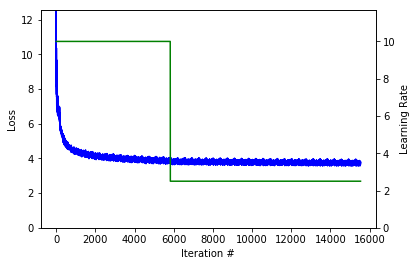

Epoch  43 results: time: 83.02s, validation loss  3.78, perplexity    43.88
Epoch 44/50 batches: 250/363 lr 2.50, loss 3.76, perplexity: 42.80


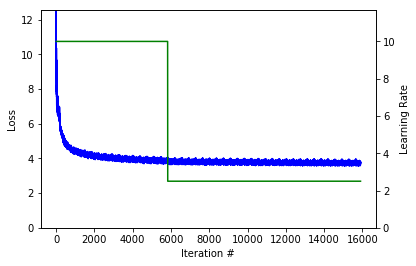

Epoch  44 results: time: 82.95s, validation loss  3.78, perplexity    43.79
Epoch 45/50 batches: 250/363 lr 2.50, loss 3.75, perplexity: 42.66


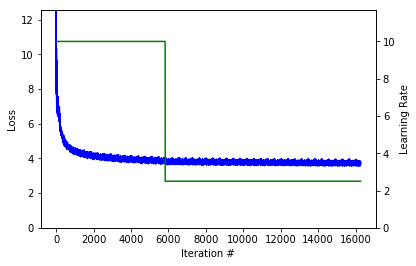

Epoch  45 results: time: 83.17s, validation loss  3.78, perplexity    43.71
Epoch 46/50 batches: 250/363 lr 2.50, loss 3.75, perplexity: 42.62


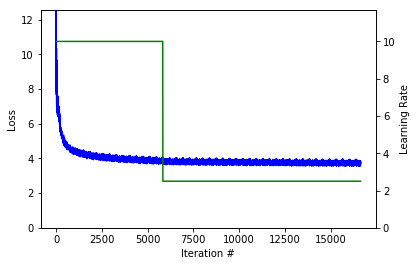

Epoch  46 results: time: 82.99s, validation loss  3.78, perplexity    43.67
Epoch 47/50 batches: 250/363 lr 2.50, loss 3.75, perplexity: 42.51


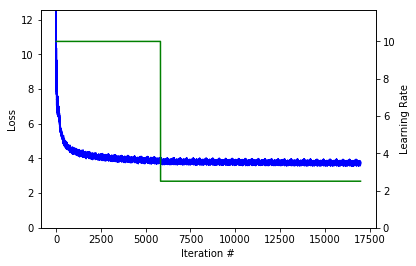

Epoch  47 results: time: 82.89s, validation loss  3.78, perplexity    43.66
Epoch 48/50 batches: 250/363 lr 2.50, loss 3.75, perplexity: 42.45


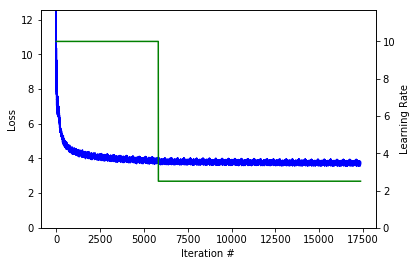

Epoch  48 results: time: 83.03s, validation loss  3.78, perplexity    43.61
Epoch 49/50 batches: 250/363 lr 2.50, loss 3.75, perplexity: 42.31


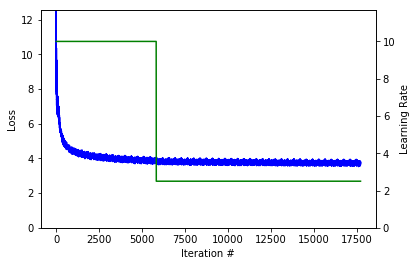

Epoch  49 results: time: 83.34s, validation loss  3.77, perplexity    43.58
Epoch 50/50 batches: 250/363 lr 2.50, loss 3.74, perplexity: 42.20


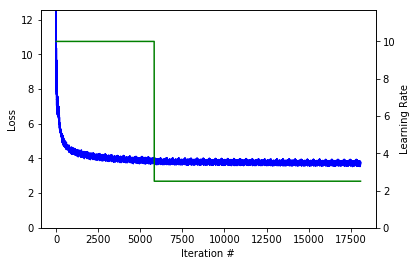

Epoch  50 results: time: 83.01s, validation loss  3.77, perplexity    43.53


/home/tyson/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel/__main__.py:49: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greately increasing memory usage. To compact weights again call flatten_parameters().


/n End of training. Test loss:  3.80, Test perplexity:    44.76


In [17]:
# At any point we can hit Ctrl+C to break out of training early
try:
    train()
except KeyboardInterrupt:
    print('='*75)
    print('Exiting from training early')
    
# Load the best saved model
with open('model_checkpoint.pt', 'rb') as f:
    model = torch.load(f)

# Run on the test data
test_loss = evaluate(test_data)
print('='*75)
print('/n End of training. Test loss: {:5.2f}, Test perplexity: {:8.2f}'.format(
    test_loss, math.exp(test_loss)
))
print('='*75)

## Generate Sample Output
Now that we've trained our model, we can generate new sentences from our model

In [18]:
random_seed = 421
num_output_words = 550

In [19]:
torch.manual_seed(random_seed)

if GPU_AVAILABLE:
    torch.cuda.manual_seed(random_seed)

with open('model_checkpoint.pt', 'rb') as f:
    model = torch.load(f)

model.eval()

if GPU_AVAILABLE:
    model.cuda()
else:
    model.cpu()

corpus = Corpus(pathname)
n_tokens = len(corpus.dictionary)
hidden = model.init_hidden(1)
input = Variable(torch.rand(1, 1).mul(n_tokens).long(), volatile=True)

if GPU_AVAILABLE:
    input.data = input.data.cuda()

def get_token_map():
    return {v: k for k, v in token_lookup().items()}

with open('output.txt', 'w') as outf:
    for i in range(num_output_words):
        output, hidden = model(input, hidden)
        word_weights = output.squeeze().data.exp().cpu()
        word_idx = torch.multinomial(word_weights, 1)[0]
        input.data.fill_(word_idx)
        word = corpus.dictionary.idx_to_word[word_idx]
        
        token_map = get_token_map()
        is_token = False
        
        if token_map.get(word):
            is_token = True
            word = token_map[word]
            
        outf.write(('' if is_token else ' ') + word)
        
        if i % logging_interval == 0:
            print('Generated {}/{} words'.format(i, num_output_words))

Generated 0/550 words
Generated 250/550 words
Generated 500/550 words


In [20]:
%%bash
cat ./output.txt

 eye. you know, professional mom.

 chief wiggum:( points, sakes- quickly) principal, i got the promise of our bus... captain!

 bart simpson: after the cookies you can assumed. that' s not of the bond.

( simpson home: int. simpson house- kitchen- a few day)

 bart simpson: ooh, moe. aw, this is great.

 marge simpson: whatever i rises you to see my son' s license like a correct: armor. i' m all late. this isn' t staring on the potentially own lunch.( sotto) at the car, i left that cursing.

 grampa simpson: they can' t go in that first man!

 lisa simpson:( flipping out intercom) the alonzo tumharé stu!

 homer simpson:( louder gasp)

 grampa simpson: what is the predicate of the same money?

 marge simpson: yeah, i want for a turkey college.

 lisa simpson:( annoyed grunt)

( hospital room: int. dining room- a little later)

 bart simpson: ah, i' ll tell ya so not a matter, hicks out here.( chuckle)

 mayor joe quimby:( scoffs, chuckles) i' ll get you, homer, the best reason.

 gary

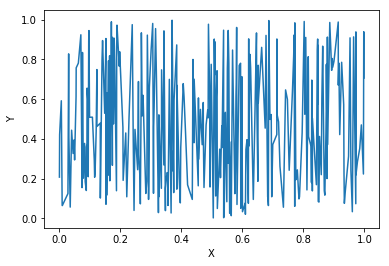

In [21]:
import matplotlib.pyplot as plt
import numpy
import math

x = numpy.random.rand(300)
y = numpy.random.rand(300)
x = numpy.sort(x, 0)
# y = numpy.sort(y, 0)

plt.plot(x, y)
plt.ylabel('Y')
plt.xlabel('X')
plt.show()
    